### Multi-label classificatio

In [1]:
# data
# https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *
from planet import f2

In [3]:
PATH = 'data/planet/'
metrics=[f2]
f_model = resnet34

In [4]:
# get random indexes
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [5]:
def get_data(size):
    tfms = tfms_from_model(f_model, sz=size, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')
# data = get_data(256)
# x,y = next(iter(data.val_dl))

In [6]:
size = 64
data = get_data(size)
data = data.resize(int(size*1.3), 'tmp') 
# for speed up training in different size (I don't understand lol)

### 1. Find learning rate

epoch      trn_loss   val_loss   f2                          
    0      0.219266   0.252883   0.810099  



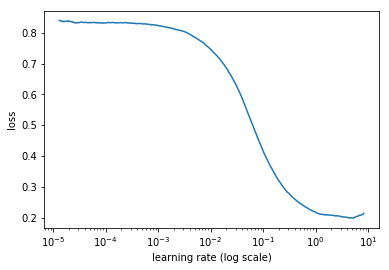

In [7]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)
learn.lr_find()
learn.sched.plot()

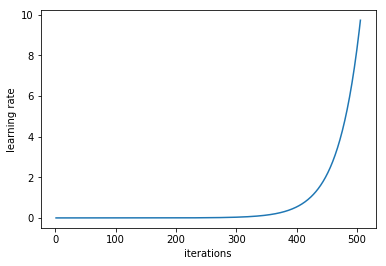

In [8]:
learn.sched.plot_lr()

### 2. Train Last Fully Connected Layer

In [9]:
lr = 0.2
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.147502   0.133557   0.882116  
    1      0.142404   0.127074   0.889562                    
    2      0.135545   0.125268   0.891469                    
    3      0.143083   0.125334   0.891131                    
    4      0.135043   0.122827   0.89384                     
    5      0.132442   0.121116   0.895872                    
    6      0.136481   0.121074   0.895984                    



[array([0.12107]), 0.8959842610506022]

### 3. Unfreeze to train all layers

In [10]:
learn.unfreeze()
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.121414   0.108838   0.908104  
    1      0.115284   0.104188   0.912876                    
    2      0.107335   0.101376   0.915801                    
    3      0.109246   0.102502   0.914473                    
    4      0.105686   0.099574   0.917341                    
    5      0.101956   0.09736    0.91882                     
    6      0.100648   0.097905   0.916928                     



[array([0.09791]), 0.9169275166415715]

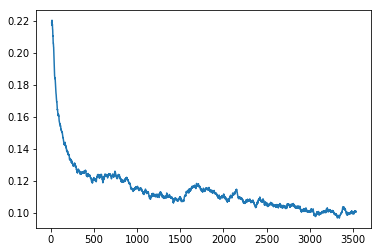

In [11]:
learn.save(f'{size}')
learn.sched.plot_loss()

In [12]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)
f2(preds,y)

0.9176534737348706

### 4. Change size to size=128 and do it again

In [13]:
size=128
learn.set_data(get_data(size))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.099673   0.096056   0.917172  
    1      0.09761    0.094443   0.918695                     
    2      0.095612   0.092754   0.920244                     
    3      0.098723   0.093459   0.920685                     
    4      0.096165   0.092413   0.920258                     
    5      0.095262   0.091854   0.921302                     
    6      0.093067   0.092229   0.920306                     



[array([0.09223]), 0.9203058229582782]

In [14]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{size}')

epoch      trn_loss   val_loss   f2                           
    0      0.094107   0.087467   0.926729  
    1      0.093256   0.088596   0.925283                     
    2      0.088469   0.085569   0.928287                     
    3      0.092706   0.087405   0.927236                     
    4      0.088144   0.085106   0.929209                     
    5      0.087158   0.083968   0.92968                      
    6      0.08545    0.083317   0.930909                     



### 5. Change size to size=256 and do it again

In [15]:
size=256
learn.set_data(get_data(size))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.093043   0.088601   0.925451  
    1      0.092159   0.08795    0.92471                      
    2      0.091634   0.086708   0.927152                     
    3      0.091252   0.08752    0.925313                     
    4      0.088267   0.086733   0.926845                     
    5      0.088922   0.086009   0.927566                     
    6      0.086664   0.0859     0.928062                     



[array([0.0859]), 0.9280619190357042]

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{size}')

epoch      trn_loss   val_loss   f2                           
    0      0.086103   0.082583   0.931609  
    1      0.087013   0.082932   0.932234                     
 92%|█████████▏| 466/506 [12:47<01:05,  1.65s/it, loss=0.0809]

### Last Accuracy

In [ ]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)
f2(preds,y)